# Seoul Apartment Price Predictions

I predicted apartment prices in Seoul based on housing location, size, floor, and age. Given the fact that a lot of South Korean people prefer apartments for residence and that apartment prices has increased substantially over the last five years, especially in Seoul, I aimed to understand what factors contribute to an increase in apartment price the most. For this data analysis project, I scraped xml format files of the transaction data for apartment sales from January 2006 to December 2020 provided by the Korean Ministry of Land, Infrastructure by using Python. 
 I tried various models to predict apartment princes in Seoul and found out that a random forest model performs with smallest prediction errors and highest $R^{2}$.

## Library Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x:'%.2f' %x)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore',category=ConvergenceWarning)
    
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import pickle

## Exploratory Analysis

In [2]:
apt_dat = pd.read_csv('apt_data_seoul.csv')
apt_dat = apt_dat.reindex(columns=['tx_year','tx_month','price','built','house_size','floor','geo_code'])
print('The number of observations:',len(apt_dat))
apt_dat.head()

The number of observations: 1249656


,tx_year,tx_month,price,built,house_size,floor,geo_code
0,2006,1,"29,500",1983,93.40,6,11110
1,2006,1,"15,741",1998,57.18,12,11110
2,2006,1,"23,198",1998,84.26,6,11110
3,2006,1,"23,198",1998,84.26,14,11110
4,2006,1,"21,535",1998,78.23,15,11110


In [3]:
print(apt_dat.dtypes)

tx_year         int64
tx_month        int64
price          object
built           int64
house_size    float64
floor           int64
geo_code        int64
dtype: object


In [4]:
apt_dat['price'] = apt_dat['price'].str.replace(',', '').astype(float)

The transaction data for apartment sales contains 10 variables:  transaction dates (tx_year, tx_month, tx_day), transaction prices (price), years that an apartment was built in (built), structure areas (house_size), on which floors sold units are located (floor), names of neighborhoods (loc_dong),  city codes (geo_code), and names of apartment complexes. 

The data spans from January 2006 to December 2020, and has 1,182,110 observations in total. 

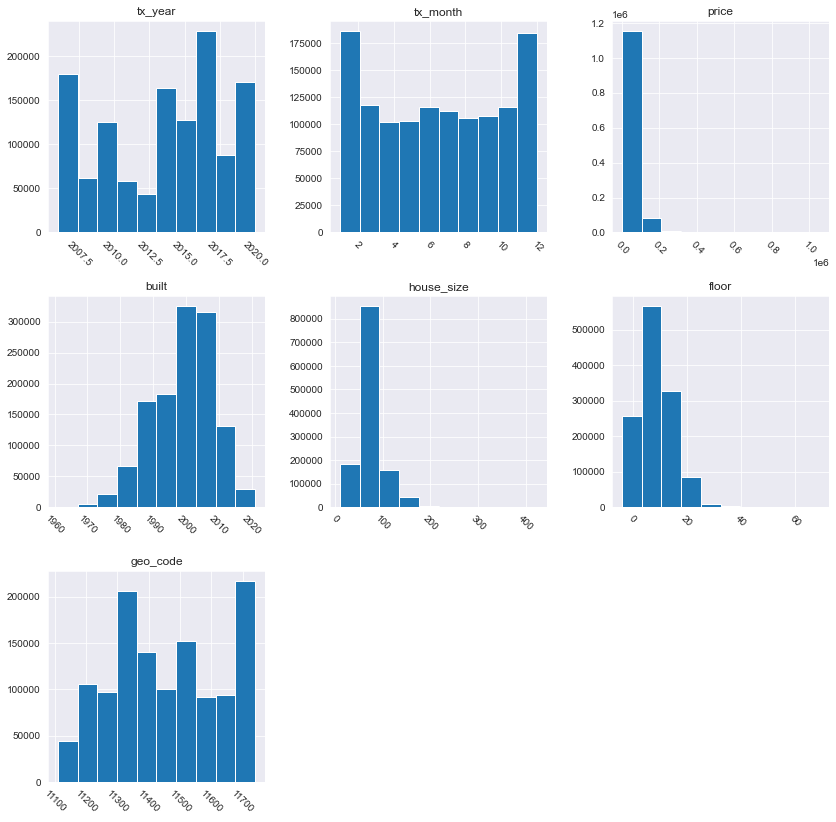

In [5]:
apt_dat.hist(figsize=(14,14),xrot=-45)
plt.show()

In [6]:
apt_dat.describe()

,tx_year,tx_month,price,built,house_size,floor,geo_code
count,1249656.00,1249656.00,1249656.00,1249656.00,1249656.00,1249656.00,1249656.00
mean,2013.46,6.50,52244.67,1998.57,77.39,8.69,11457.26
std,4.41,3.34,40055.33,9.11,28.75,5.85,170.45
min,2006.00,1.00,350.00,1961.00,10.02,-4.00,11110.00
25%,2009.00,4.00,28300.00,1992.00,59.69,4.00,11320.00
50%,2014.00,7.00,41300.00,2000.00,82.50,8.00,11440.00
75%,2017.00,9.00,62500.00,2005.00,84.96,12.00,11590.00
max,2020.00,12.00,1053000.00,2021.00,424.32,69.00,11740.00


## Data Cleaning

In [7]:
# Drop duplicates
apt_dat = apt_dat.drop_duplicates()
print(apt_dat.shape)

(1165705, 7)


In [8]:
# Remove observations with negative floors
print(len(apt_dat[apt_dat.floor < 0]))
apt_dat = apt_dat[apt_dat.floor > 0]

258


In [9]:
for column in apt_dat.columns[3:7]:
    print('The number of missing observations for {} is'.format(column),apt_dat[column].isnull().sum())

The number of missing observations for built is 0
The number of missing observations for house_size is 0
The number of missing observations for floor is 0
The number of missing observations for geo_code is 0


In [10]:
apt_dat['floor_area'] = pd.cut(apt_dat['house_size'], bins= [0,40,85,149, float('Inf')],labels=['small','medium','big','huge'])

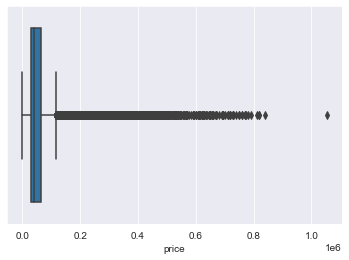

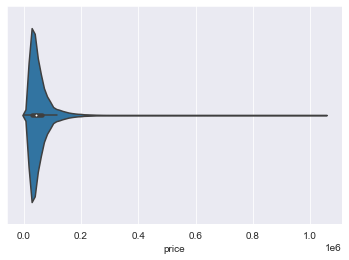

In [11]:
# Box plot of 'price' using the Seaborn library
sns.boxplot(x = 'price', data = apt_dat)
plt.show()

# Violin plot
sns.violinplot(x = 'price', data = apt_dat)
plt.show()

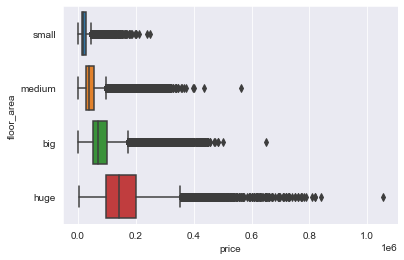

In [12]:
sns.boxplot(y='floor_area',x='price',data=apt_dat)
plt.show()

## Feature Engineering

In [13]:
apt_dat['apt_age'] = apt_dat.tx_year - apt_dat.built
apt_dat.apt_age.describe()

count   1165447.00
mean         15.21
std           9.35
min          -1.00
25%           8.00
50%          14.00
75%          21.00
max          59.00
Name: apt_age, dtype: float64

In [14]:
print(sum(apt_dat.apt_age <0))

39


The amounts and types of property taxes and tax refunds vary depending on floor sizes. Therefore, I create four categorical variables ralted to *house_size*

In [15]:
apt_dat['small'] = (apt_dat.house_size <= 40).astype(int)
apt_dat['medium'] = ((apt_dat.house_size > 40) & (apt_dat.house_size <=85)).astype(int)

apt_dat['big'] = ((apt_dat.house_size > 85) & (apt_dat.house_size <= 149)).astype(int)
apt_dat['huge'] = (apt_dat.house_size > 149).astype(int)

Finally, I created dummy variables for each city in Seoul based on *geo_code*, to capture time-invariant effects that each city has on apartment sale prices. 

In [16]:
apt_dat = pd.get_dummies(apt_dat,columns=['geo_code'])

In [17]:
apt_dat.drop('built',axis=1,inplace=True)

In [18]:
apt_dat.drop('house_size',axis=1,inplace=True)

In [37]:
apt_dat.to_csv('ab_table_apt.csv')
print(apt_dat.shape)

(1165447, 34)


In [45]:
apt_dat.head(10)

,tx_year,tx_month,price,floor,apt_age,small,medium,big,huge,geo_code_11110,...,geo_code_11500,geo_code_11530,geo_code_11545,geo_code_11560,geo_code_11590,geo_code_11620,geo_code_11650,geo_code_11680,geo_code_11710,geo_code_11740
0,2006,1,29500.00,6,23,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2006,1,15741.00,12,8,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2006,1,23198.00,6,8,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2006,1,23198.00,14,8,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2006,1,21535.00,15,8,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,2006,1,21500.00,6,7,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,2006,1,20000.00,8,7,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,2006,1,16800.00,8,14,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,2006,1,16500.00,11,13,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,2006,1,28000.00,7,13,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## Algorithm Selection

In this section, I tried five algorithms to predict apartment prices in Seoul, along multiple sets of hyperparameters for each algorithm. First, since the goal of this project is to predict prices based on housing features, regressions arise as a natural starting point. However, to circumvent possible overfitting issues, I implemented Lasso, Ridge, and Elastic Net regressions. Second, compared to regression based algorithms, decision tree based algorithms perform better if there is non-linear relationship between explanatory and dependent variables. Therefore, I also conducted two decision tree based model, random forest and gradient boosting. 

In [49]:
pipelines = {
    'lasso': make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge': make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [50]:
lasso_hyperparameters = {'lasso__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

ridge_hyperparameters = {'ridge__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}

enet_hyperparameters = {
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [100,200],
    'randomforestregressor__max_features': ['auto','sqrt',0.33]
}
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators': [100,200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [51]:
hyperparameters = {'lasso': lasso_hyperparameters,
                  'ridge': ridge_hyperparameters,
                   'enet': enet_hyperparameters,
                   'rf': rf_hyperparameters,
                   'gb': gb_hyperparameters}

In [52]:
pipelines.items()

dict_items([('lasso', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))])), ('ridge', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=123))])), ('enet', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnet', ElasticNet(random_state=123))])), ('rf', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=123))])), ('gb', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=123))]))])

## Model Training

In [19]:
y = apt_dat.price
X = apt_dat.drop('price',axis=1)

In [20]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

In [21]:
print(len(X_train),len(X_test),len(y_train),len(y_test))

932357 233090 932357 233090


In [59]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name],cv=10,n_jobs=1)
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(name, 'has been fitted.')

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


In [60]:
for name, model in fitted_models.items():
    print(name, model.best_score_)

lasso 0.6184719339330191
ridge 0.6184719332582199
enet 0.6184719382746241
rf 0.8575980810386599
gb 0.8346475609239723


In [61]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print('-------')
    print('R^2:',r2_score(y_test,pred))
    print('MAEL', mean_absolute_error(y_test,pred))
    print()

lasso
-------
R^2: 0.6180274729296913
MAEL 16070.348713951713

ridge
-------
R^2: 0.6180274891767195
MAEL 16070.324535666754

enet
-------
R^2: 0.6180278845134268
MAEL 16070.037963560033

rf
-------
R^2: 0.857092394398934
MAEL 9167.106189212207

gb
-------
R^2: 0.8335748912820518
MAEL 10436.025179072507



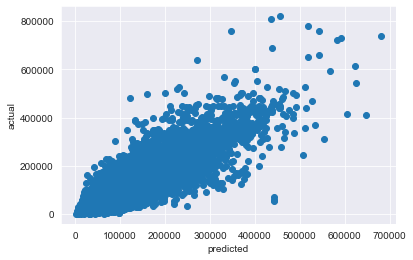

In [62]:
plt.scatter(fitted_models['rf'].predict(X_test),y_test)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [63]:
print(fitted_models['rf'].best_estimator_.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('randomforestregressor', RandomForestRegressor(n_estimators=200, random_state=123))], 'verbose': False, 'standardscaler': StandardScaler(), 'randomforestregressor': RandomForestRegressor(n_estimators=200, random_state=123), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0.0, 'randomforestregressor__criterion': 'mse', 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__max_samples': None, 'randomforestregressor__min_impurity_decrease': 0.0, 'randomforestregressor__min_impurity_split': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_weight_fraction_leaf': 0.0, 'randomforestregressor__n_estimators': 200, 'randomf

In [64]:
with open('final_model.pkl','wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

## Insights & Analysis

Model training results show that a random forest algorithm has the smallest prediction error and the largest $R^2$.

Although I only used apartment sales data for this project, there are other types of housing, such as multi-unit houses (similar to townhouses and condos) and single family houses. It is likely that people consider location more than housing type. If this is the case, incorporating those housing types in the analysis will be able to take into account the interplay between various housing types within location. 